In [1]:
from visualize import plot_blackjack_value_function, plot_blackjack_policy, plot_hyperparameter_search_results
from env import create_blackjack_env, get_four_rooms_env, get_race_track_env, TrackType
from policy import BlackJackPolicy, EpsilonPolicy
from algorithms import on_policy_monte_carlo_prediction_fv, on_policy_monte_carlo_fv, off_policy_monte_carlo
from utils import load_or_compute_and_cache, policy_to_dict

import os
import matplotlib.pyplot as plt
import numpy as np


In [2]:
# setup
NUM_EXPERIMENTS = 10
NUM_EPSIODES = 10_000
STABLE = False # whether or not to use cached results from each experiment
BASE_CACHE_DIR = './cache'
FIG_BASE_DIR = './figs'
if not os.path.exists(FIG_BASE_DIR):
    os.makedirs(FIG_BASE_DIR)
if not os.path.exists(BASE_CACHE_DIR):
    os.makedirs(BASE_CACHE_DIR)

### Implementing First Visit Monte Carlo Policy Evaluation for BlackJack

Default policy is to stick if the sum of the cards is 20 or 21, and hit otherwise.

In [3]:
CACHED_BKJ_VALUE_FUNCTION_10K = os.path.join(BASE_CACHE_DIR, 'bj_value_function_10k.pkl')
CACHED_BKJ_VALUE_FUNCTION_500K = os.path.join(BASE_CACHE_DIR, 'bj_value_function_500k.pkl')


blackjack_env = create_blackjack_env()
bkj_policy = lambda s: BlackJackPolicy.default_blackjack_policy(s)

# 1. Monte Carlo Prediction
bkj_value_function_10k = load_or_compute_and_cache(
    CACHED_BKJ_VALUE_FUNCTION_10K,
    on_policy_monte_carlo_prediction_fv,
    blackjack_env,
    bkj_policy,
    0.9
)

bkj_value_function_500k = load_or_compute_and_cache(
    CACHED_BKJ_VALUE_FUNCTION_500K,
    on_policy_monte_carlo_prediction_fv,
    blackjack_env,
    bkj_policy,
    0.9,
    num_episodes=500_000
)


/var/folders/dn/qrl3gd_j3w5csrv58d43z62r0000gn/T/ipykernel_53989/1272370475.py:18: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  plt.savefig(BJK_VALUE_FUNCTION_10k_VS_500k)


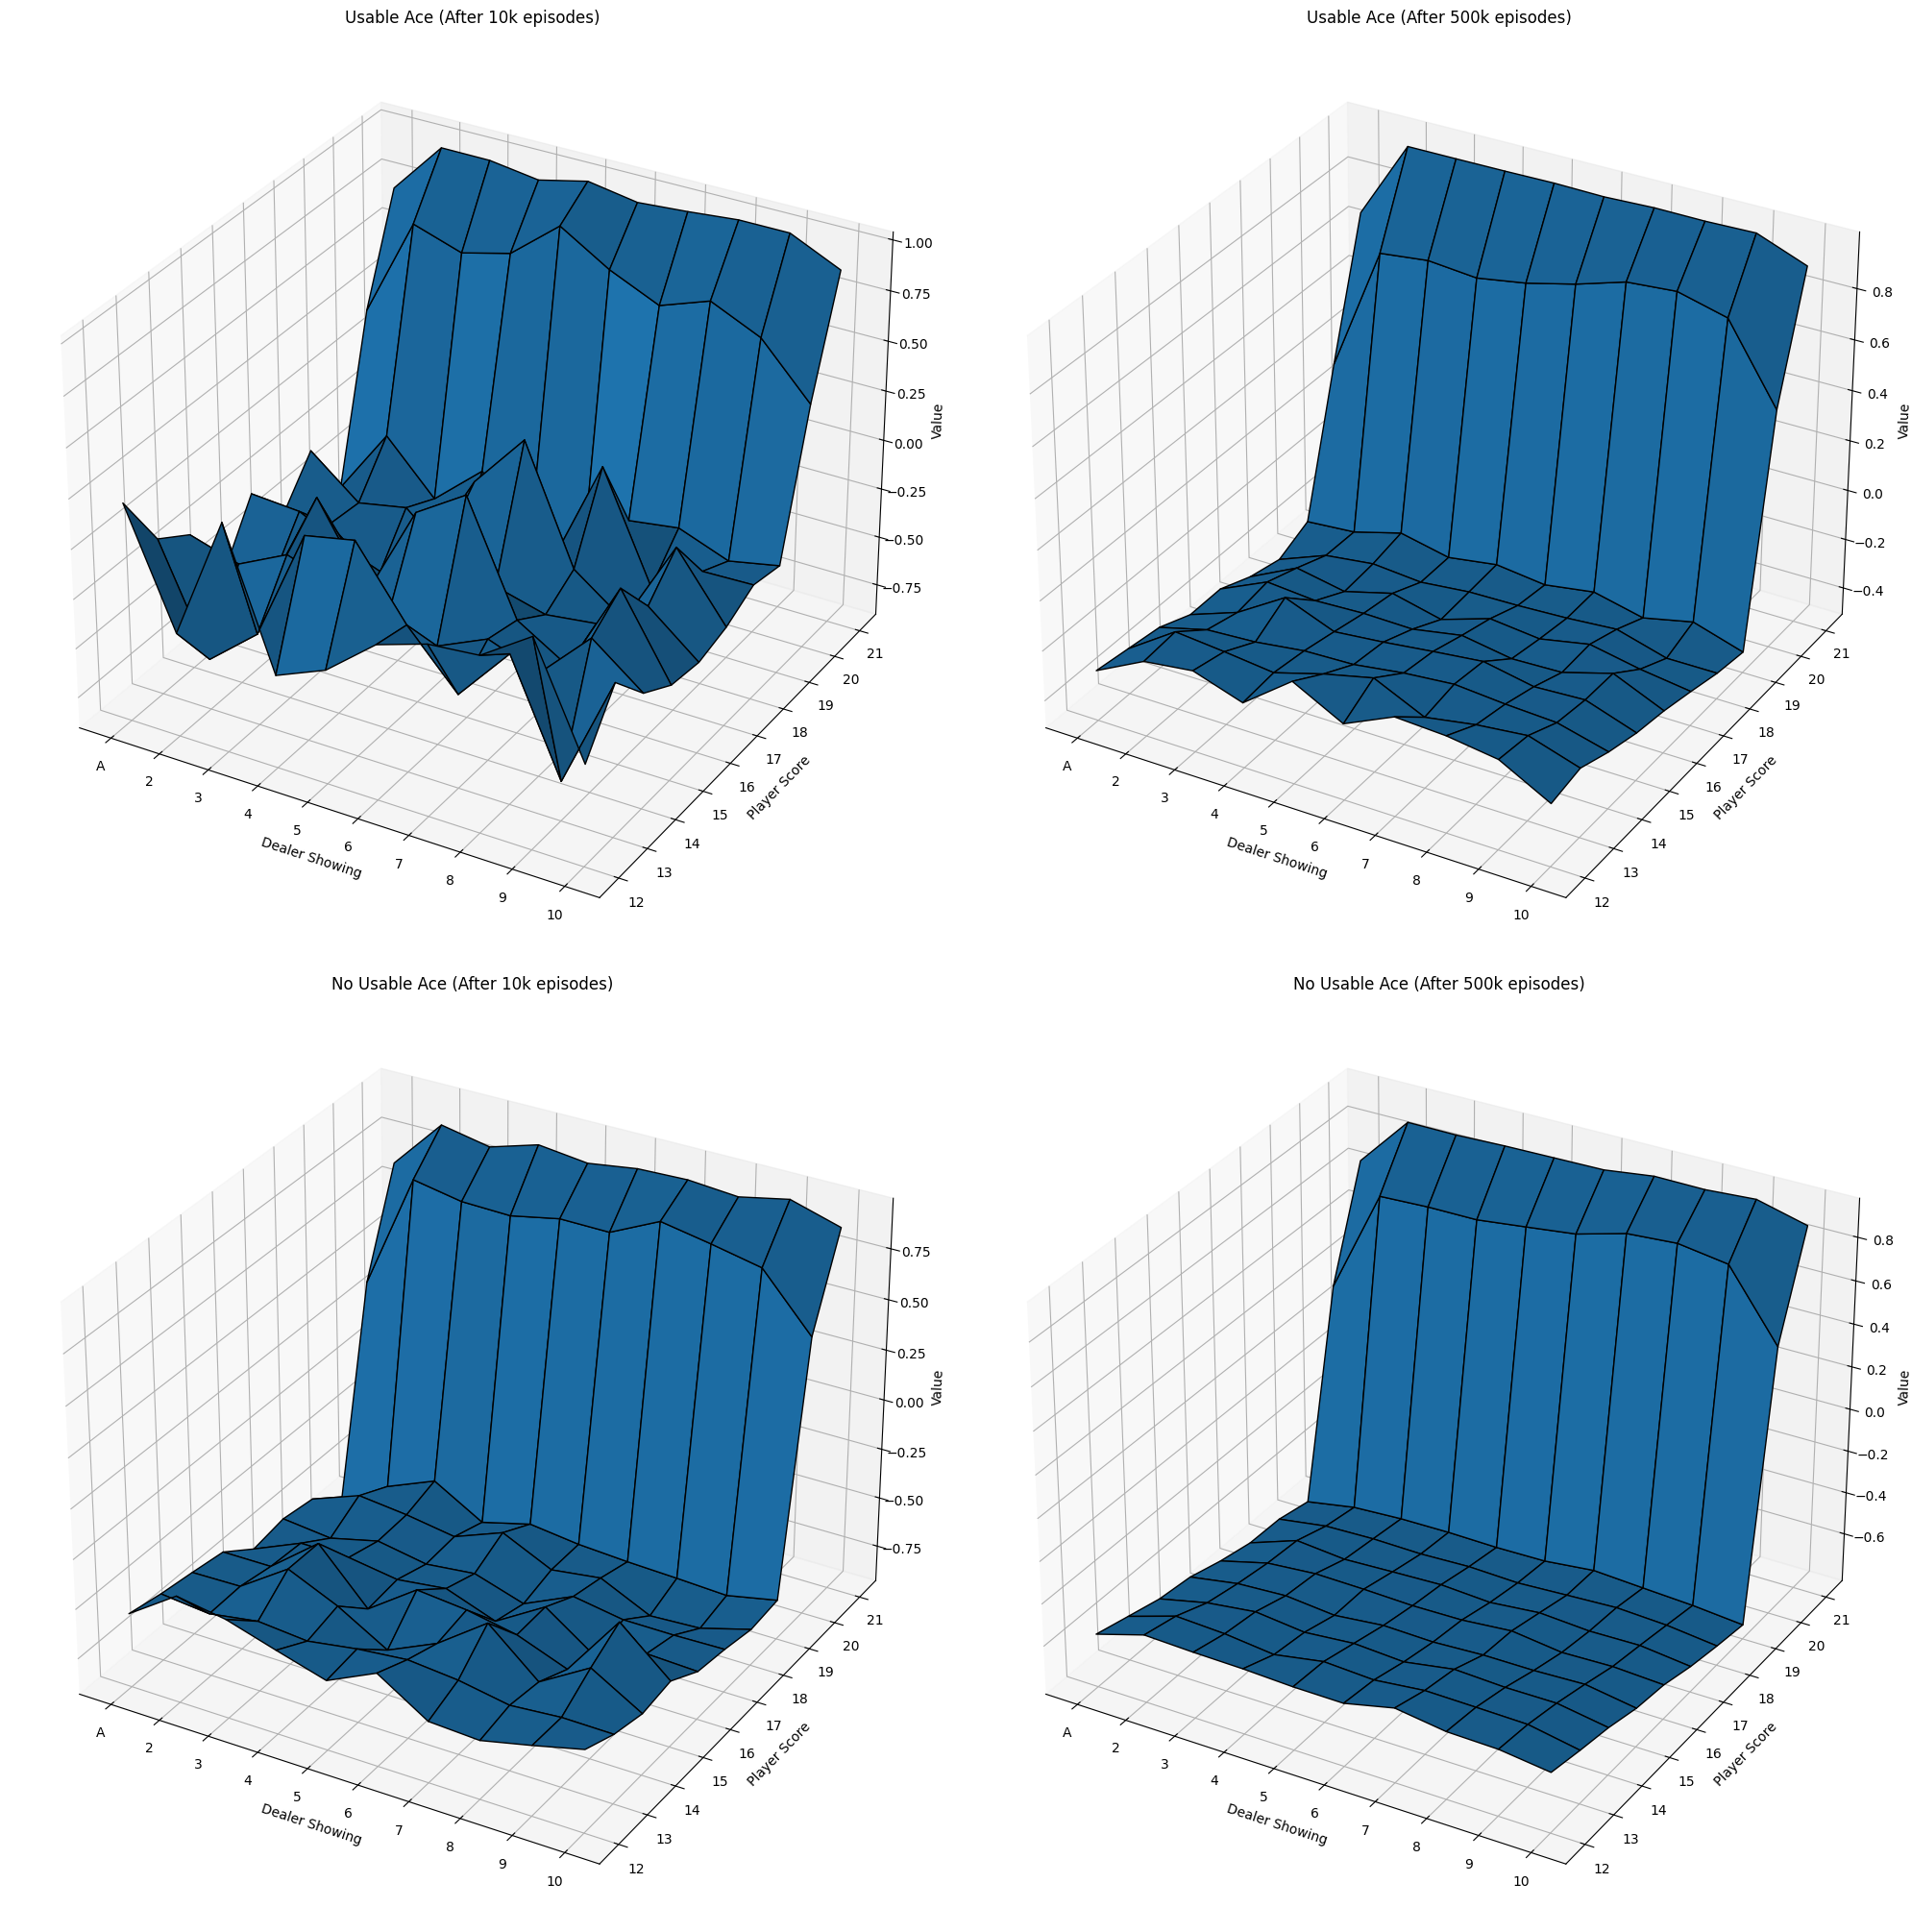

In [4]:
BJK_VALUE_FUNCTION_10k_VS_500k = os.path.join(FIG_BASE_DIR, 'bjk_value_function_10k_vs_500k.png')

fig = plt.figure(figsize=(20, 20), layout='constrained')
ax1 = fig.add_subplot(2, 2, 1, projection='3d') 
plot_blackjack_value_function(ax1, bkj_value_function_10k, True, 'Usable Ace (After 10k episodes)')

# Plot for the situation without a usable ace
ax2 = fig.add_subplot(2, 2, 2, projection='3d')
plot_blackjack_value_function(ax2, bkj_value_function_500k, True, 'Usable Ace (After 500k episodes)')

ax3 = fig.add_subplot(2, 2, 3, projection='3d') 
plot_blackjack_value_function(ax3, bkj_value_function_10k, False, 'No Usable Ace (After 10k episodes)')

# Plot for the situation without a usable ace
ax4 = fig.add_subplot(2, 2, 4, projection='3d')
plot_blackjack_value_function(ax4, bkj_value_function_500k, False, 'No Usable Ace (After 500k episodes)')

plt.savefig(BJK_VALUE_FUNCTION_10k_VS_500k)


### Implementing First Visit Monte Carlo Control for BlackJack (Monte Carlo ES)

In [5]:
OPTIMAL_BJK = os.path.join(BASE_CACHE_DIR, 'bjk_optimal.pkl')

bkj_v_star, bkj_policy_dict = load_or_compute_and_cache(
    OPTIMAL_BJK,
    on_policy_monte_carlo_fv,
    blackjack_env,
    lambda Q: BlackJackPolicy.create_greedy_policy(Q),
    0.9,
    post_process=lambda data: (data[0], policy_to_dict(data[1], list(data[0].keys()))),
    num_episodes=1_000_000,
    es=True)
bkj_policy_star = lambda s: bkj_policy_dict[s]

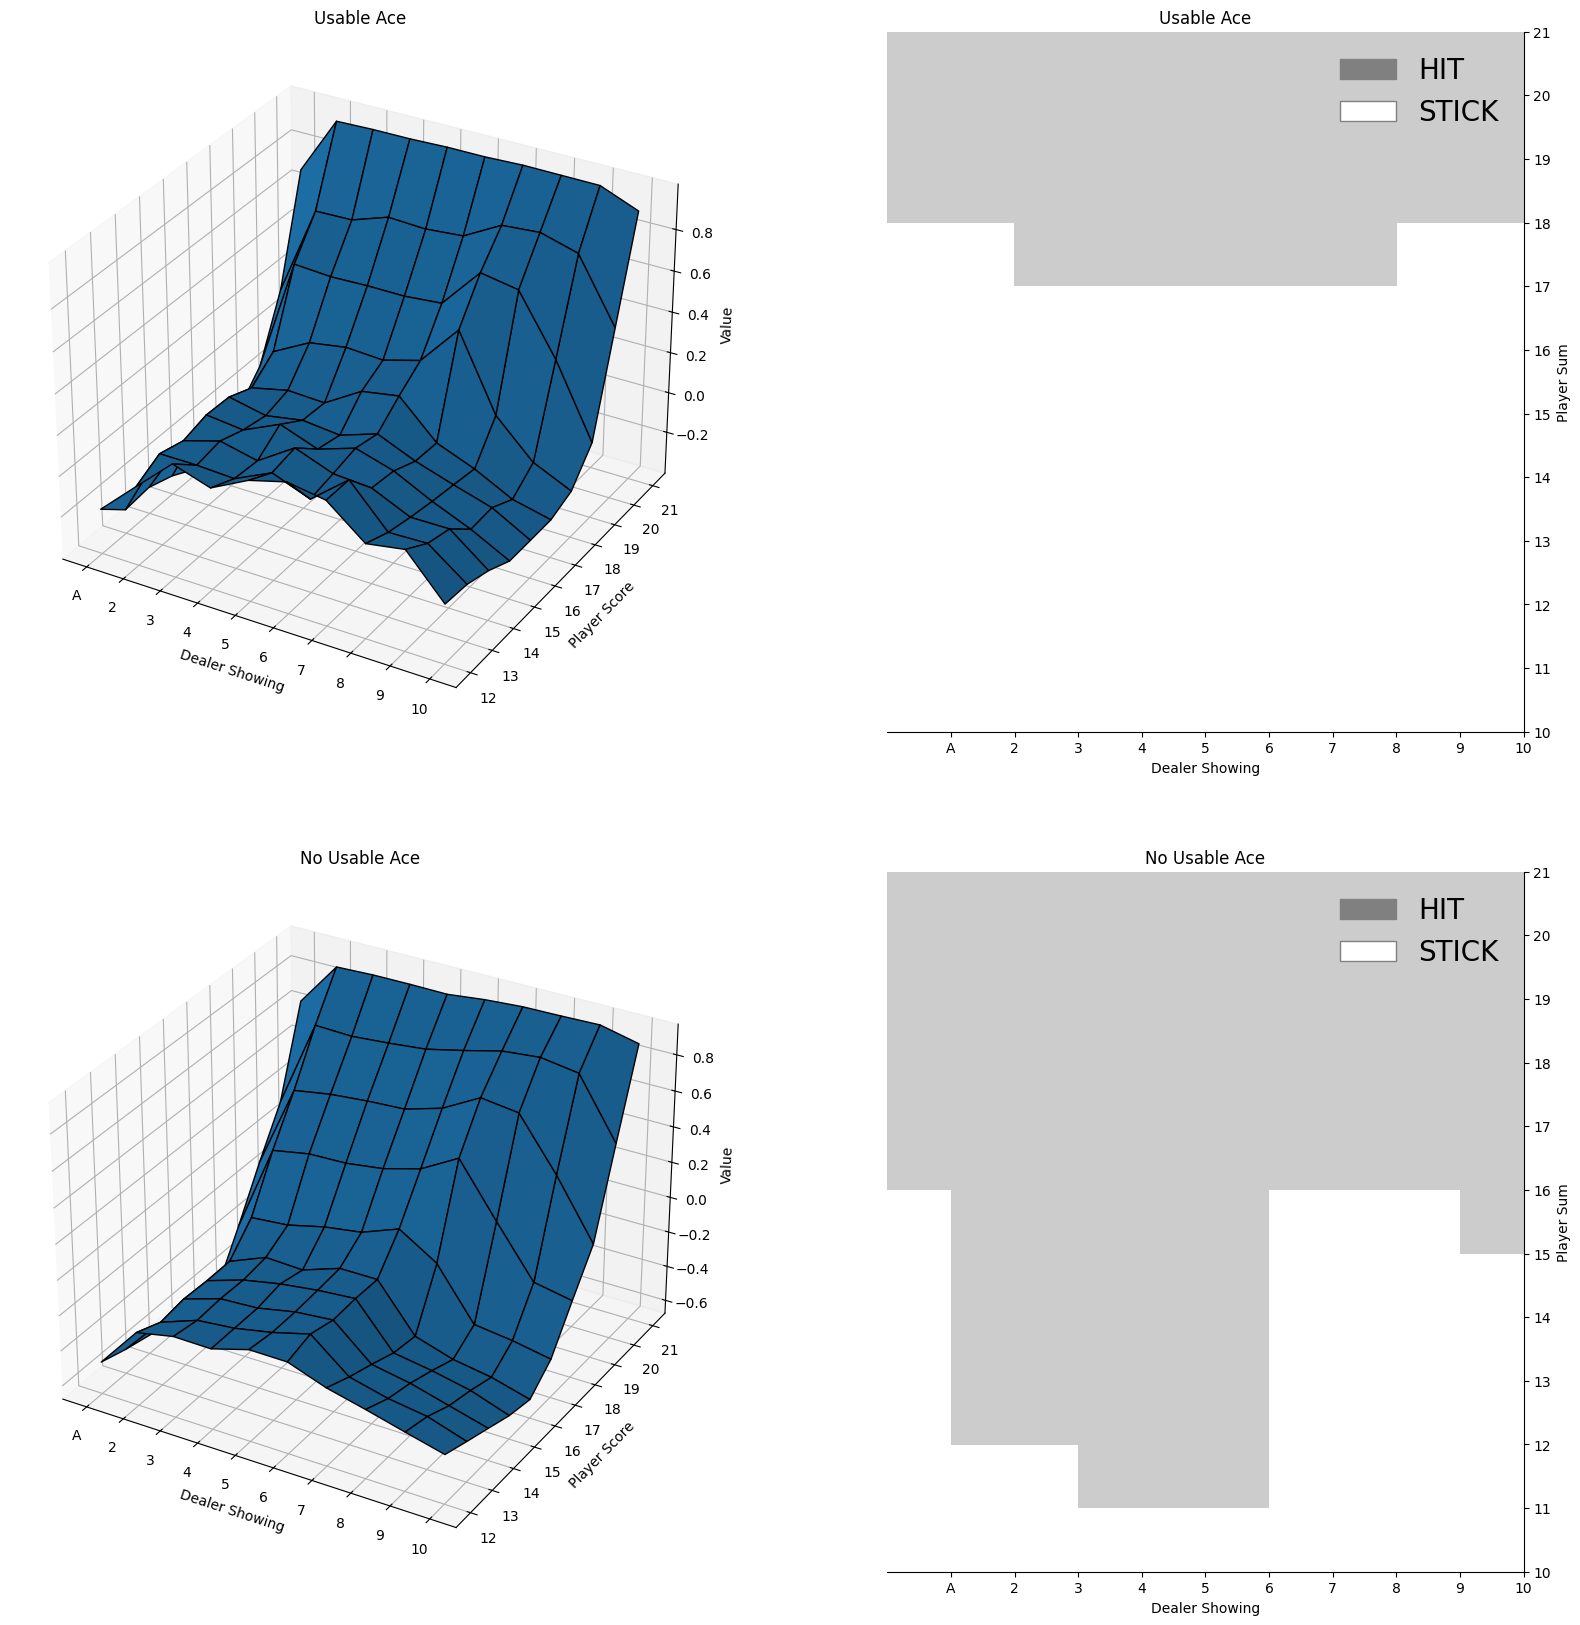

In [6]:
BJK_OPTIMAL_V_FUNCTION = os.path.join(FIG_BASE_DIR, 'bjk_optimal_v_function.png')

fig = plt.figure(figsize=(20, 20))

ax1 = fig.add_subplot(2, 2, 1, projection='3d') 
plot_blackjack_value_function(ax1, bkj_v_star, True, 'Usable Ace')

ax2 = fig.add_subplot(2, 2, 2) 
plot_blackjack_policy(ax2, bkj_policy_star, True, 'Usable Ace')

ax3 = fig.add_subplot(2, 2, 3, projection='3d') 
plot_blackjack_value_function(ax3, bkj_v_star, False, 'No Usable Ace')

ax4 = fig.add_subplot(2, 2, 4) 
plot_blackjack_policy(ax4, bkj_policy_star, False, 'No Usable Ace')
plt.savefig(BJK_OPTIMAL_V_FUNCTION)
plt.show()


### On Policy Monte Carlo Control on Four Room Grid World

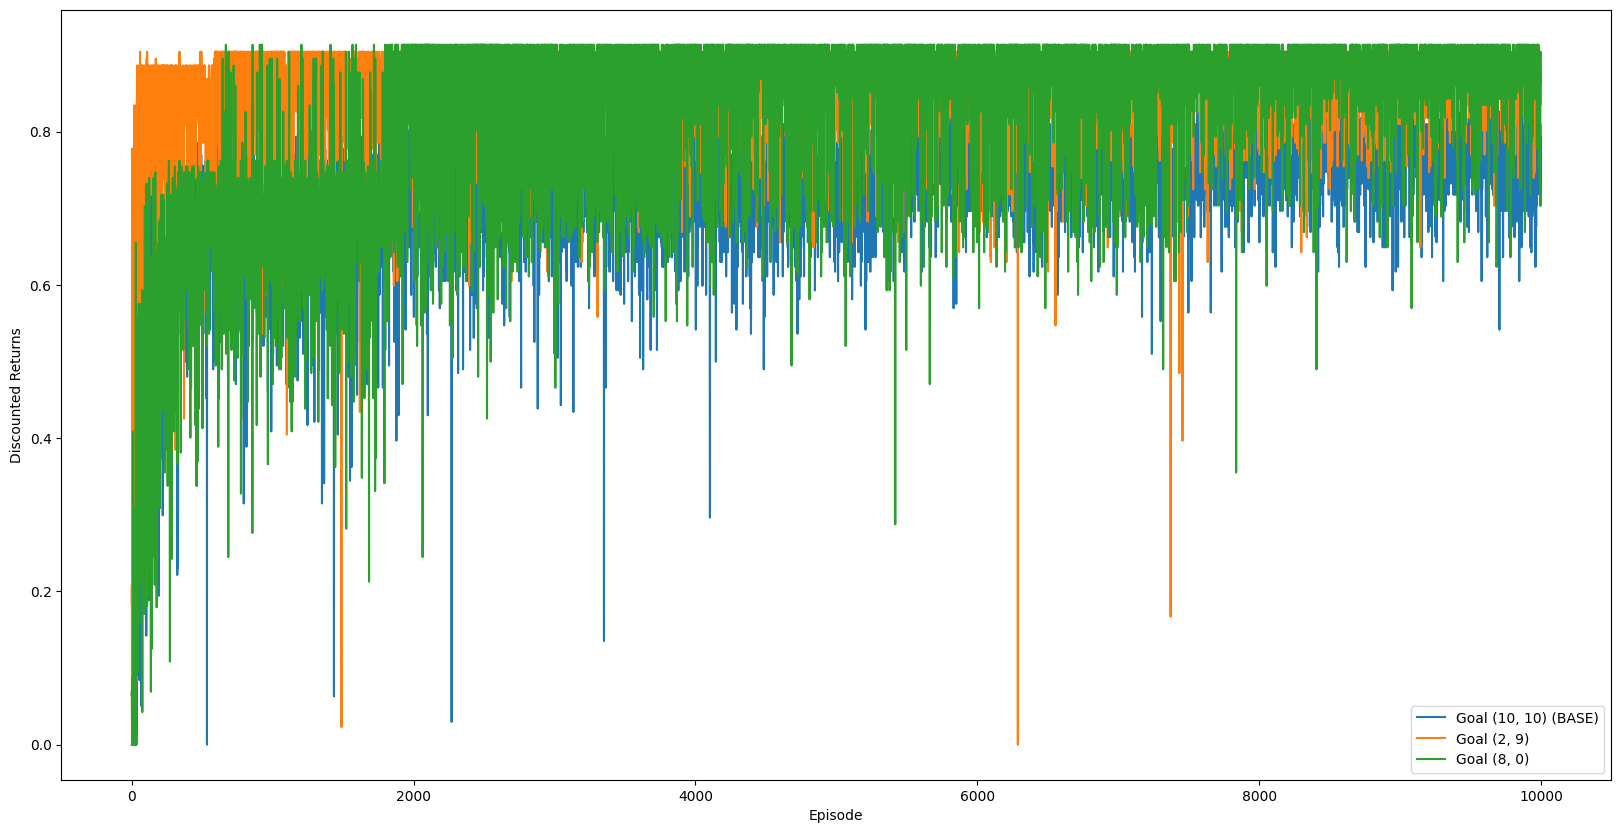

In [7]:
MONTE_CARLO_CONTROL_RANDOM_START = os.path.join(FIG_BASE_DIR, 'monte_carlo_control_random_start.png')
OPTIMAL_4ROOM_BASE = os.path.join(BASE_CACHE_DIR, 'four_room_base_optimal.pkl')
OPTIMAL_4ROOM_GOAL_2_9 = os.path.join(BASE_CACHE_DIR, 'four_room_goal_2_9_optimal.pkl')
OPTIMAL_4ROOM_GOAL_8_0= os.path.join(BASE_CACHE_DIR, 'four_room_goal_8_0_optimal.pkl')

four_room_base = get_four_rooms_env()
four_room_env_goal_2_9 = get_four_rooms_env(goal_pos=(2,9))
four_room_env_goal_8_0 = get_four_rooms_env(goal_pos=(8,0))

base_returns = load_or_compute_and_cache(
    OPTIMAL_4ROOM_BASE,
    on_policy_monte_carlo_fv,
    four_room_base,
    lambda Q: EpsilonPolicy.create_epsilon_soft_policy(Q, 0.1,4),
    0.99,
    post_process=lambda data: data[2],
    num_episodes=10_000)

goal_9_2_returns = load_or_compute_and_cache(
    OPTIMAL_4ROOM_GOAL_2_9,
    on_policy_monte_carlo_fv,
    four_room_env_goal_2_9,
    lambda Q: EpsilonPolicy.create_epsilon_soft_policy(Q, 0.1,4),
    0.99,
    post_process=lambda data: data[2],
    num_episodes=10_000)

goal_8_0_returns = load_or_compute_and_cache(
    OPTIMAL_4ROOM_GOAL_8_0,
    on_policy_monte_carlo_fv,
    four_room_env_goal_8_0,
    lambda Q: EpsilonPolicy.create_epsilon_soft_policy(Q, 0.1,4),
    0.99,
    post_process=lambda data: data[2],
    num_episodes=10_000)

### plot returns for each experiment
fig, ax = plt.subplots(1, 1, figsize=(20, 10))

ax.plot(base_returns, label=f'Goal {four_room_base.unwrapped.goal_pos} (BASE)')
ax.plot(goal_9_2_returns, label=f'Goal {four_room_env_goal_2_9.unwrapped.goal_pos}')
ax.plot(goal_8_0_returns, label=f'Goal {four_room_env_goal_8_0.unwrapped.goal_pos}')
ax.set_xlabel('Episode')
ax.set_ylabel('Discounted Returns')
ax.set_title('')
ax.legend()
plt.savefig(MONTE_CARLO_CONTROL_RANDOM_START)
plt.show()

### Comparing $\epsilon$-greedy and On Policy Monte Carlo Control on Four Room Grid World

Warning: following code is not optimized for performance, but for readability and understanding. So running the code may take some time.

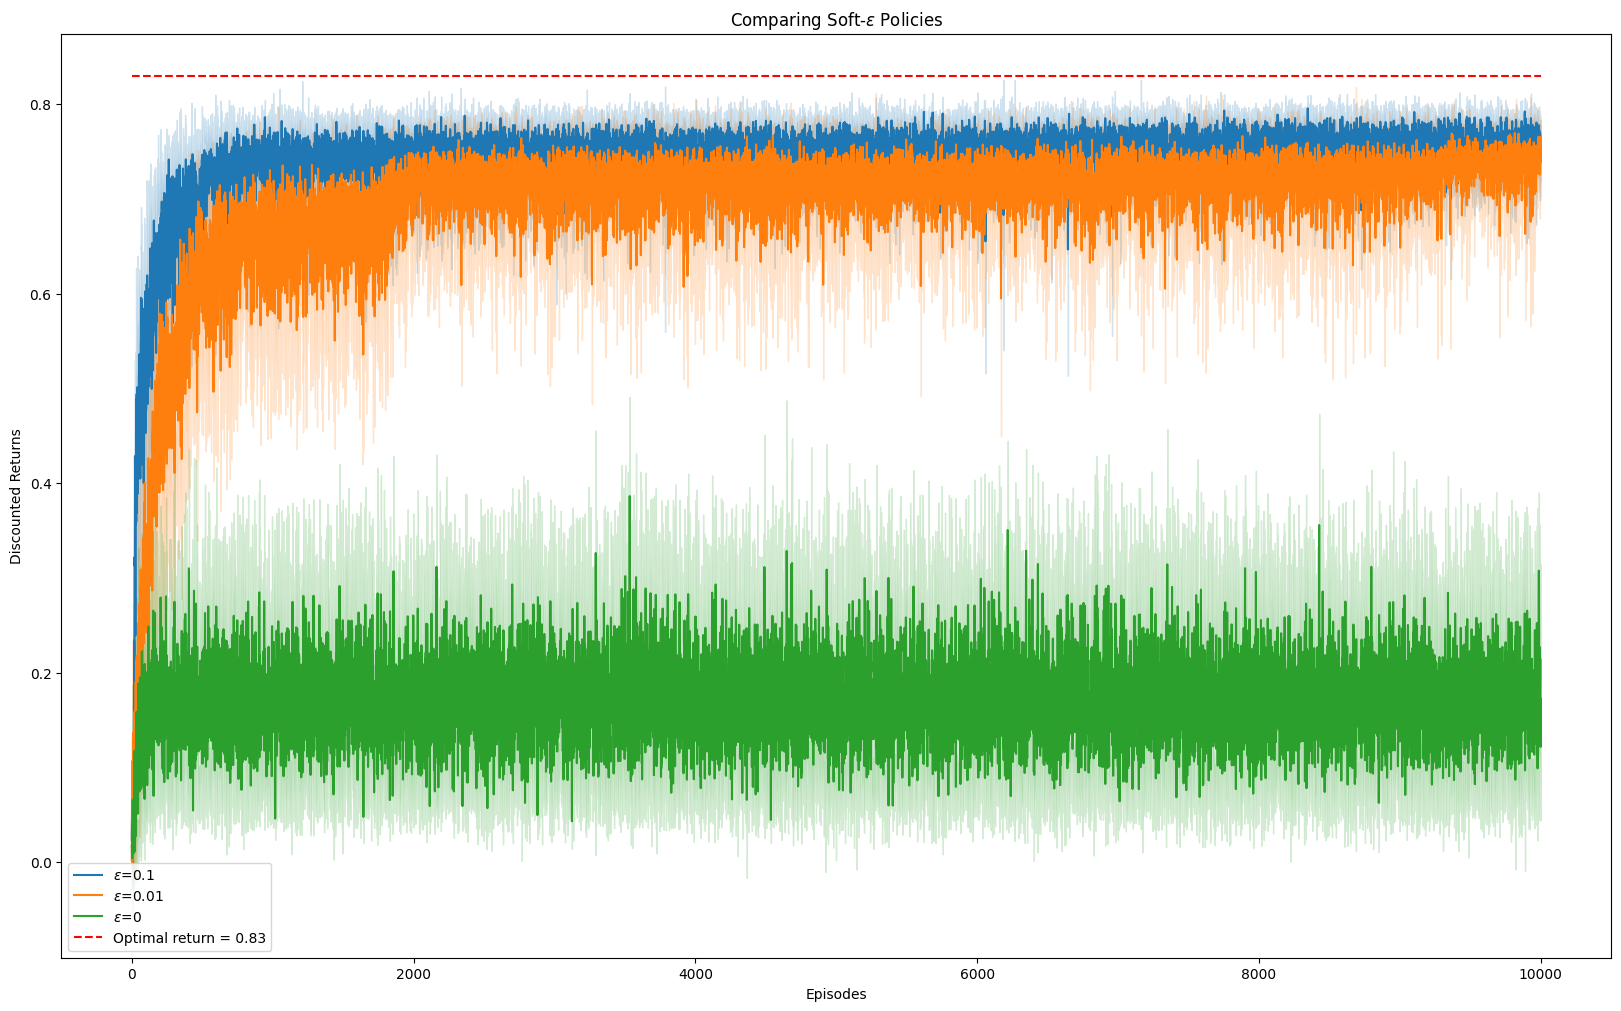

In [8]:
FOUR_ROOM_SOFT_EPSILON_COMPARISON = os.path.join(BASE_CACHE_DIR, 'four_room_soft_epsilon_comparison.pkl')

epsilons = [0.1, 0.01, 0]
four_room_base = get_four_rooms_env()


def compare_soft_policies(env, num_episodes, epsilons, num_experiments):
    all_returns = np.zeros((len(epsilons), num_experiments, num_episodes))
    for j, epsilon in enumerate(epsilons):
        for i in range(num_experiments):
            _, __, returns = on_policy_monte_carlo_fv(env, lambda Q: EpsilonPolicy.create_epsilon_soft_policy(Q, epsilon, env.action_space.n), 0.99, num_episodes=num_episodes)
            all_returns[j, i, :] = returns
    return all_returns

all_returns = load_or_compute_and_cache(
    FOUR_ROOM_SOFT_EPSILON_COMPARISON,
    compare_soft_policies,
    four_room_base,
    NUM_EPSIODES,
    epsilons,
    NUM_EXPERIMENTS
)

COMPARING_EPSILONS_FIG = os.path.join(FIG_BASE_DIR, 'comparing_epsilons.png')
plot_hyperparameter_search_results(all_returns, "$\\epsilon$", epsilons, NUM_EXPERIMENTS, NUM_EPSIODES, save_path=COMPARING_EPSILONS_FIG, title="Comparing Soft-$\\epsilon$ Policies")


### RaceTrack Environment

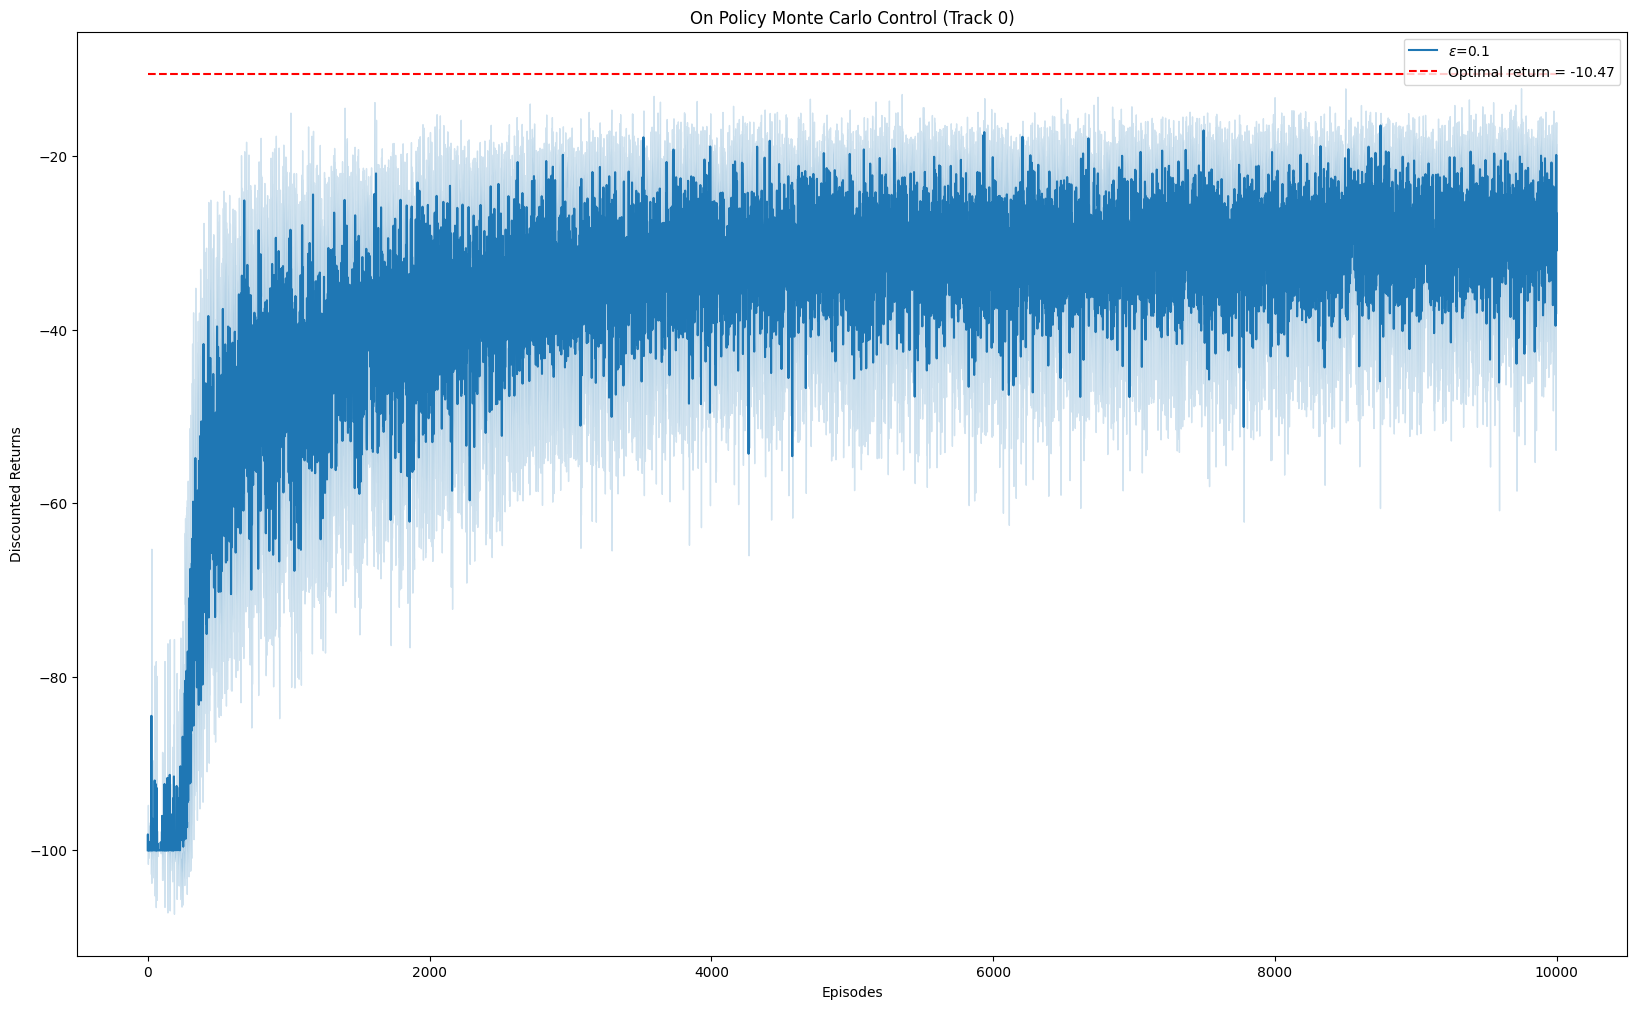

In [9]:
ON_POLICY_RETURNS_RACE_TRACK_0 = os.path.join(BASE_CACHE_DIR, 'on_policy_race_track_0_returns.pkl')
TRACK_0_ON_POLICY_FIG = os.path.join(FIG_BASE_DIR, 'track_0_on_policy.png')


rt_env_track_0 = get_race_track_env(TrackType.Track0)

returns_track_0 = load_or_compute_and_cache(
    ON_POLICY_RETURNS_RACE_TRACK_0,
    compare_soft_policies,
    rt_env_track_0,
    NUM_EPSIODES,
    [0.1],
    NUM_EXPERIMENTS
)

plot_hyperparameter_search_results(returns_track_0, "$\\epsilon$", [0.1], NUM_EXPERIMENTS, NUM_EPSIODES, title="On Policy Monte Carlo Control (Track 0)", save_path=TRACK_0_ON_POLICY_FIG)

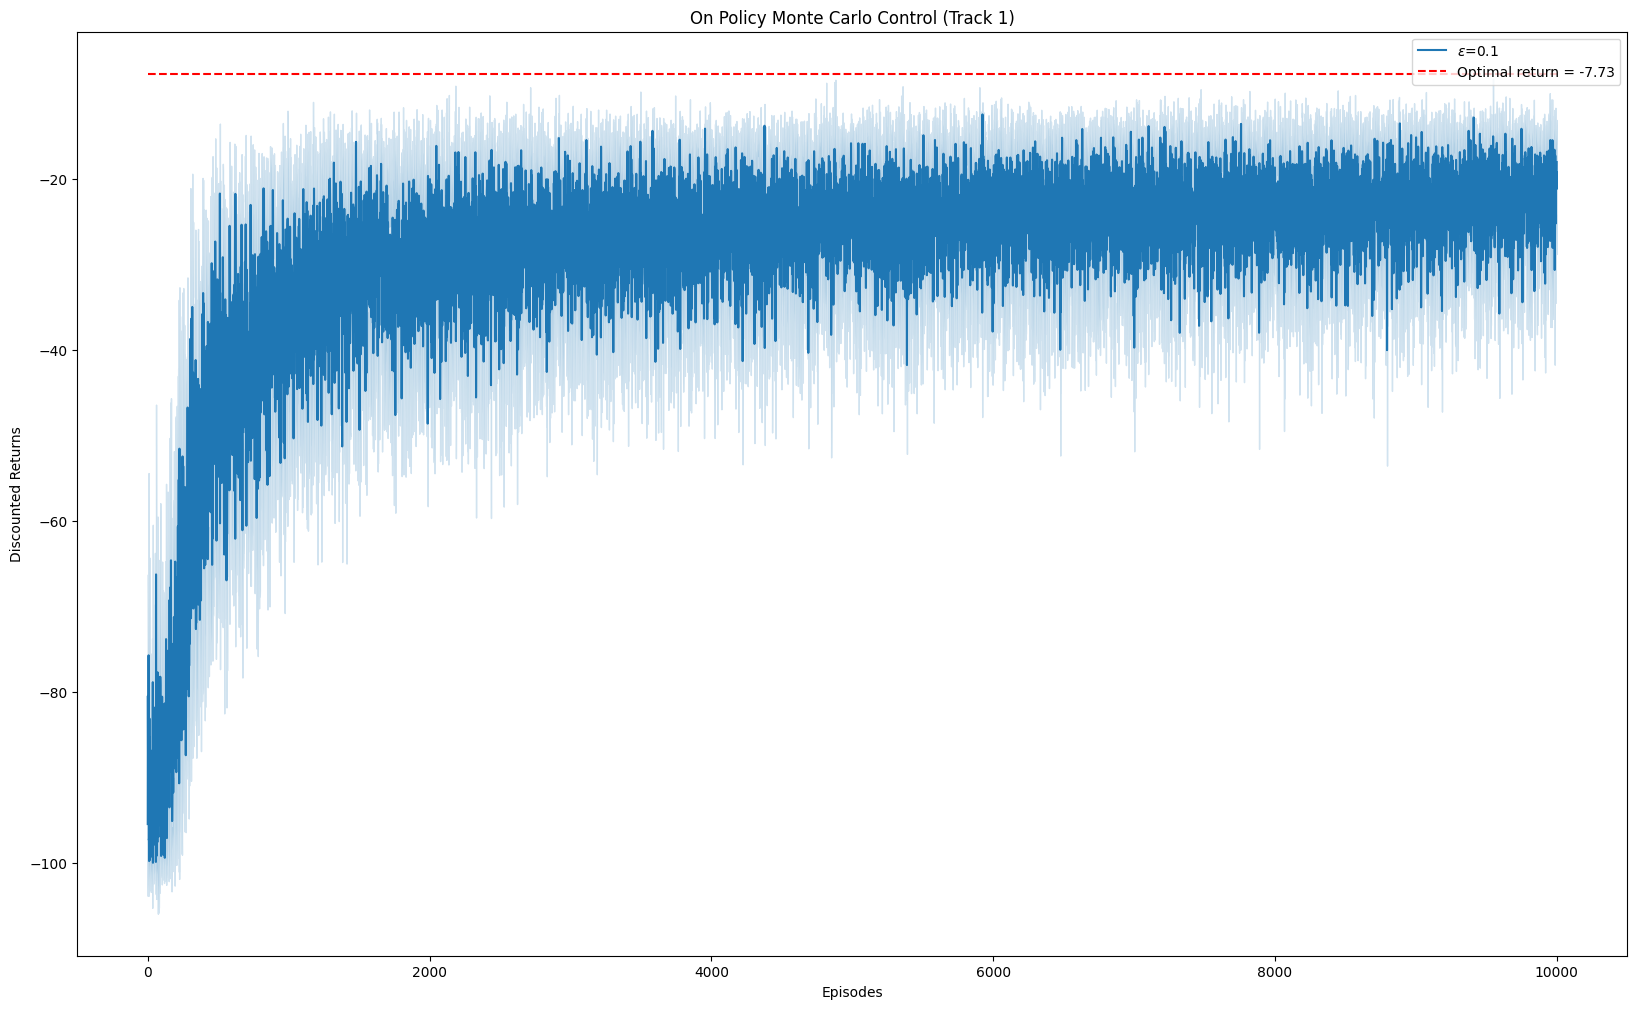

In [10]:
ON_POLICY_RETURNS_RACE_TRACK_1 = os.path.join(BASE_CACHE_DIR, 'on_policy_race_track_1_returns.pkl')
TRACK_1_ON_POLICY_FIG = os.path.join(FIG_BASE_DIR, 'track_1_on_policy.png')

rt_env_track_1 = get_race_track_env(TrackType.Track1)

returns_track_1 = load_or_compute_and_cache(
    ON_POLICY_RETURNS_RACE_TRACK_1,
    compare_soft_policies,
    rt_env_track_1,
    NUM_EPSIODES,
    [0.1],
    NUM_EXPERIMENTS
)

plot_hyperparameter_search_results(returns_track_1, "$\\epsilon$", [0.1], NUM_EXPERIMENTS, NUM_EPSIODES, title="On Policy Monte Carlo Control (Track 1)", save_path=TRACK_1_ON_POLICY_FIG)

  0%|          | 0/10000 [00:00<?, ?it/s]/Users/johnhenryrudden/anaconda3/envs/School/lib/python3.12/site-packages/gymnasium/utils/passive_env_checker.py:168: DeprecationWarning: WARN: Current gymnasium version requires that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.deprecation(
/Users/johnhenryrudden/anaconda3/envs/School/lib/python3.12/site-packages/gymnasium/utils/passive_env_checker.py:181: DeprecationWarning: WARN: Current gymnasium version requires that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.deprecation(
100%|██████████| 10000/10000 [10:16<00:00, 16.21it/s]


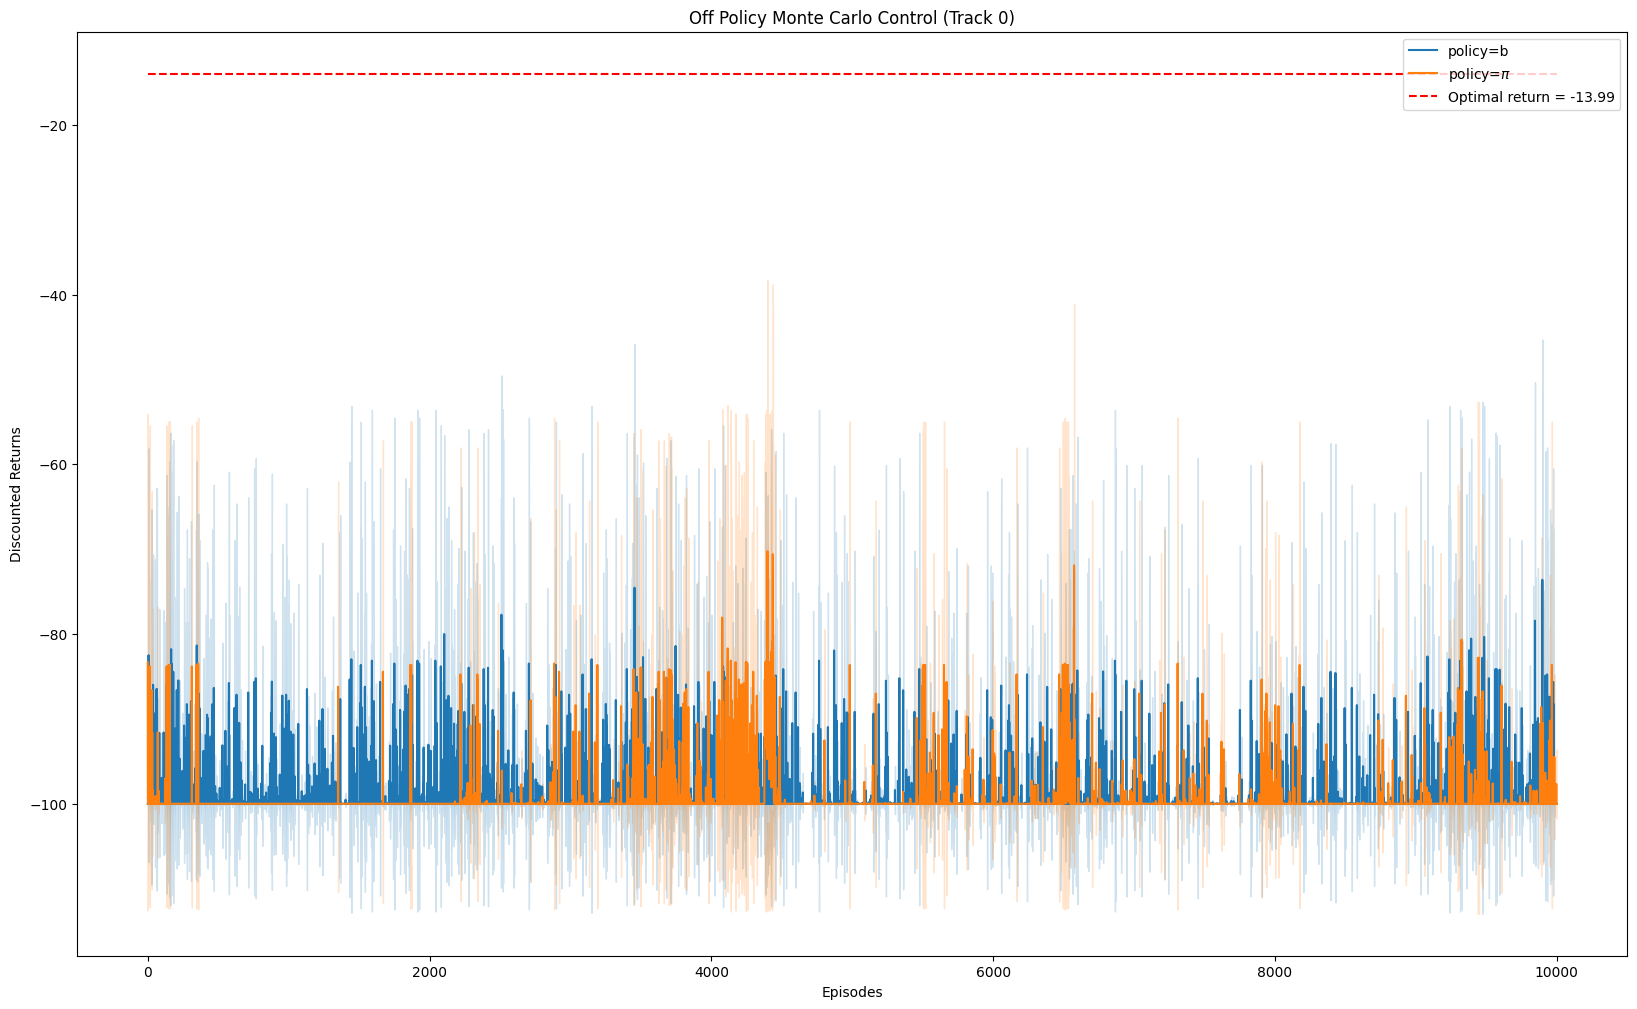

In [11]:
OFF_POLICY_RETURNS_RACE_TRACK_0 = os.path.join(BASE_CACHE_DIR, 'off_policy_race_track_0_returns.pkl')
TRACK_0_OFF_POLICY_FIG = os.path.join(FIG_BASE_DIR, 'track_0_off_policy.png')
NUM_EXPERIMENTS = 5


rt_env_track_0 = get_race_track_env(TrackType.Track0)

def compare_off_policies(env, num_episodes, epsilons, num_experiments):
    all_returns = np.zeros((2, num_experiments, num_episodes))
    for i in range(num_experiments):
        _, __, returns = off_policy_monte_carlo(env, lambda Q: EpsilonPolicy.create_epsilon_soft_policy(Q, 0.1, env.action_space.n), 0.99, num_episodes=num_episodes)
        all_returns[:, i, :] = returns
    return all_returns

returns_track_0 = load_or_compute_and_cache(
    OFF_POLICY_RETURNS_RACE_TRACK_0,
    compare_off_policies,
    rt_env_track_0,
    NUM_EPSIODES,
    [0.1],
    NUM_EXPERIMENTS
)

plot_hyperparameter_search_results(returns_track_0, "policy", ['b', '$\\pi$'], NUM_EXPERIMENTS, NUM_EPSIODES, title="Off Policy Monte Carlo Control (Track 0)", save_path=TRACK_0_ON_POLICY_FIG)

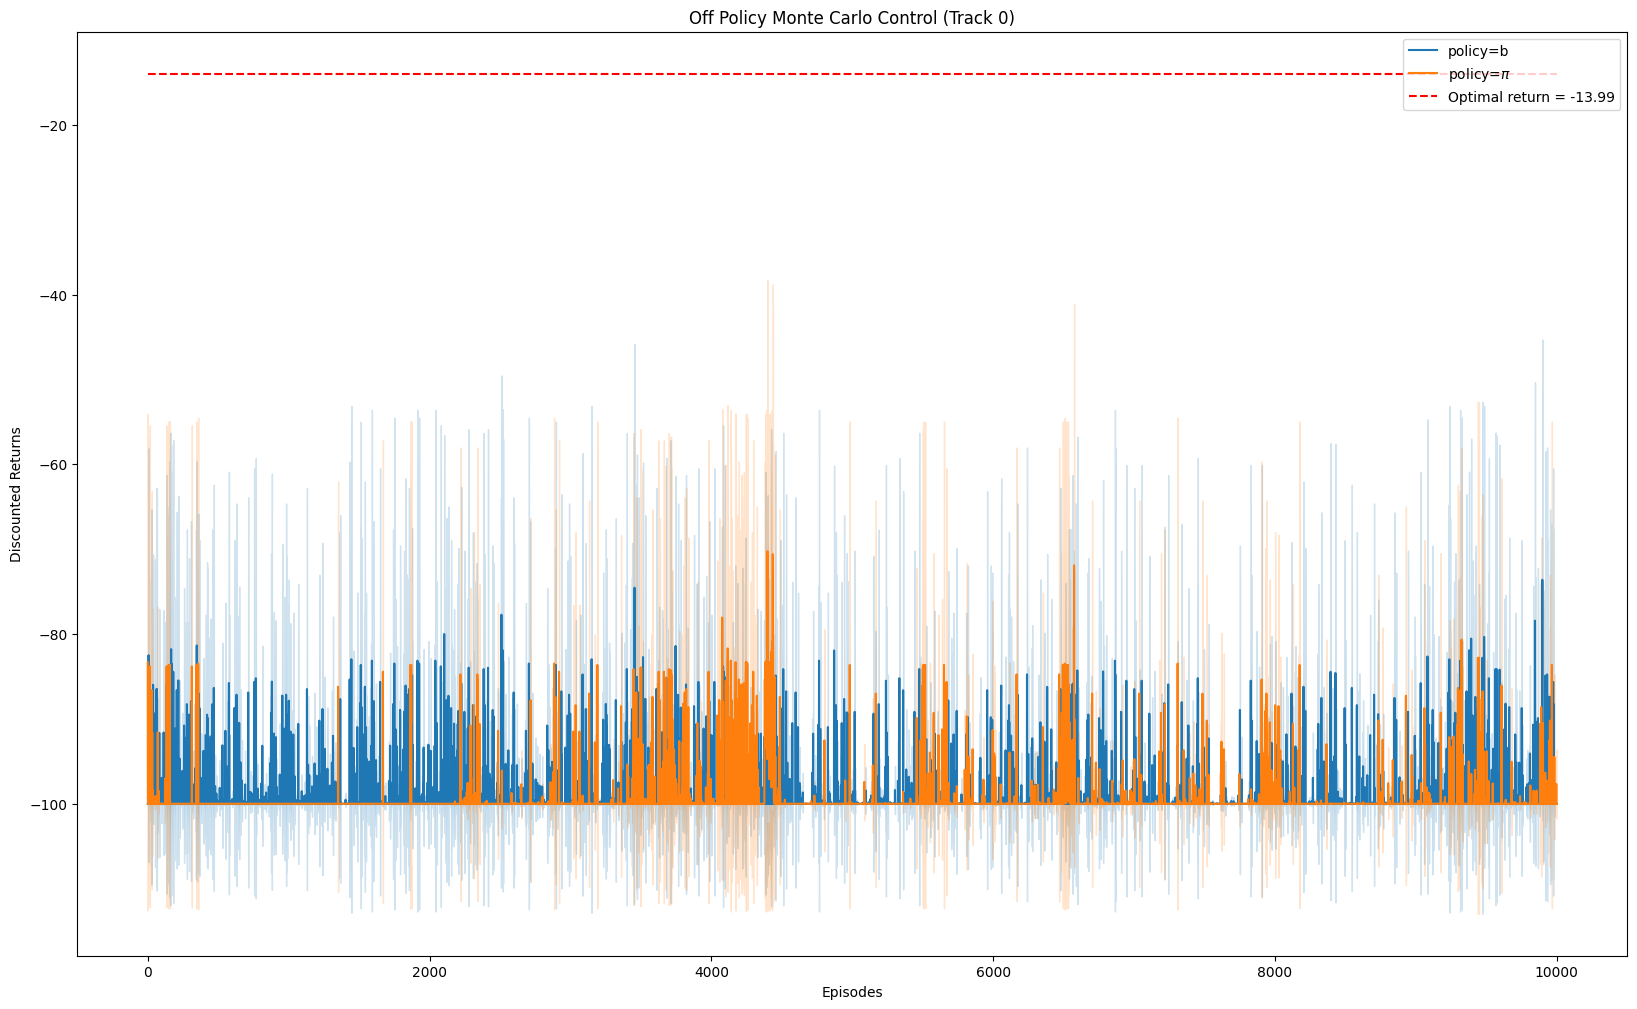

In [13]:
OFF_POLICY_RETURNS_RACE_TRACK_1 = os.path.join(BASE_CACHE_DIR, 'off_policy_race_track_1_returns.pkl')
TRACK_1_OFF_POLICY_FIG = os.path.join(FIG_BASE_DIR, 'track_1_off_policy.png')


rt_env_track_1 = get_race_track_env(TrackType.Track1)

returns_track_1 = load_or_compute_and_cache(
    OFF_POLICY_RETURNS_RACE_TRACK_1,
    compare_off_policies,
    rt_env_track_1,
    NUM_EPSIODES,
    [0.1],
    2
)

plot_hyperparameter_search_results(returns_track_0, "policy", ['b', '$\\pi$'], NUM_EXPERIMENTS, NUM_EPSIODES, title="Off Policy Monte Carlo Control (Track 0)", save_path=TRACK_0_ON_POLICY_FIG)